In [3]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sbn

from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize

from scipy.signal import cwt
from scipy.signal import morlet
import pywt
import torch
import torch.nn as nn
import torchaudio
from scipy import signal
from tqdm import tqdm_notebook
from torchvision import transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
!pip install torchviz
from torchviz import make_dot

try:
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
except:
    print("Mounting Failed.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Mounted at /content/gdrive


In [4]:
data = pd.read_csv("/content/gdrive/MyDrive/emotions.csv")
print(data['label'].value_counts())
label_mapping = {'NEGATIVE': 0, 'NEUTRAL': 1, 'POSITIVE': 2}
data['label'] = data['label'].replace(label_mapping)

NEUTRAL     716
NEGATIVE    708
POSITIVE    708
Name: label, dtype: int64


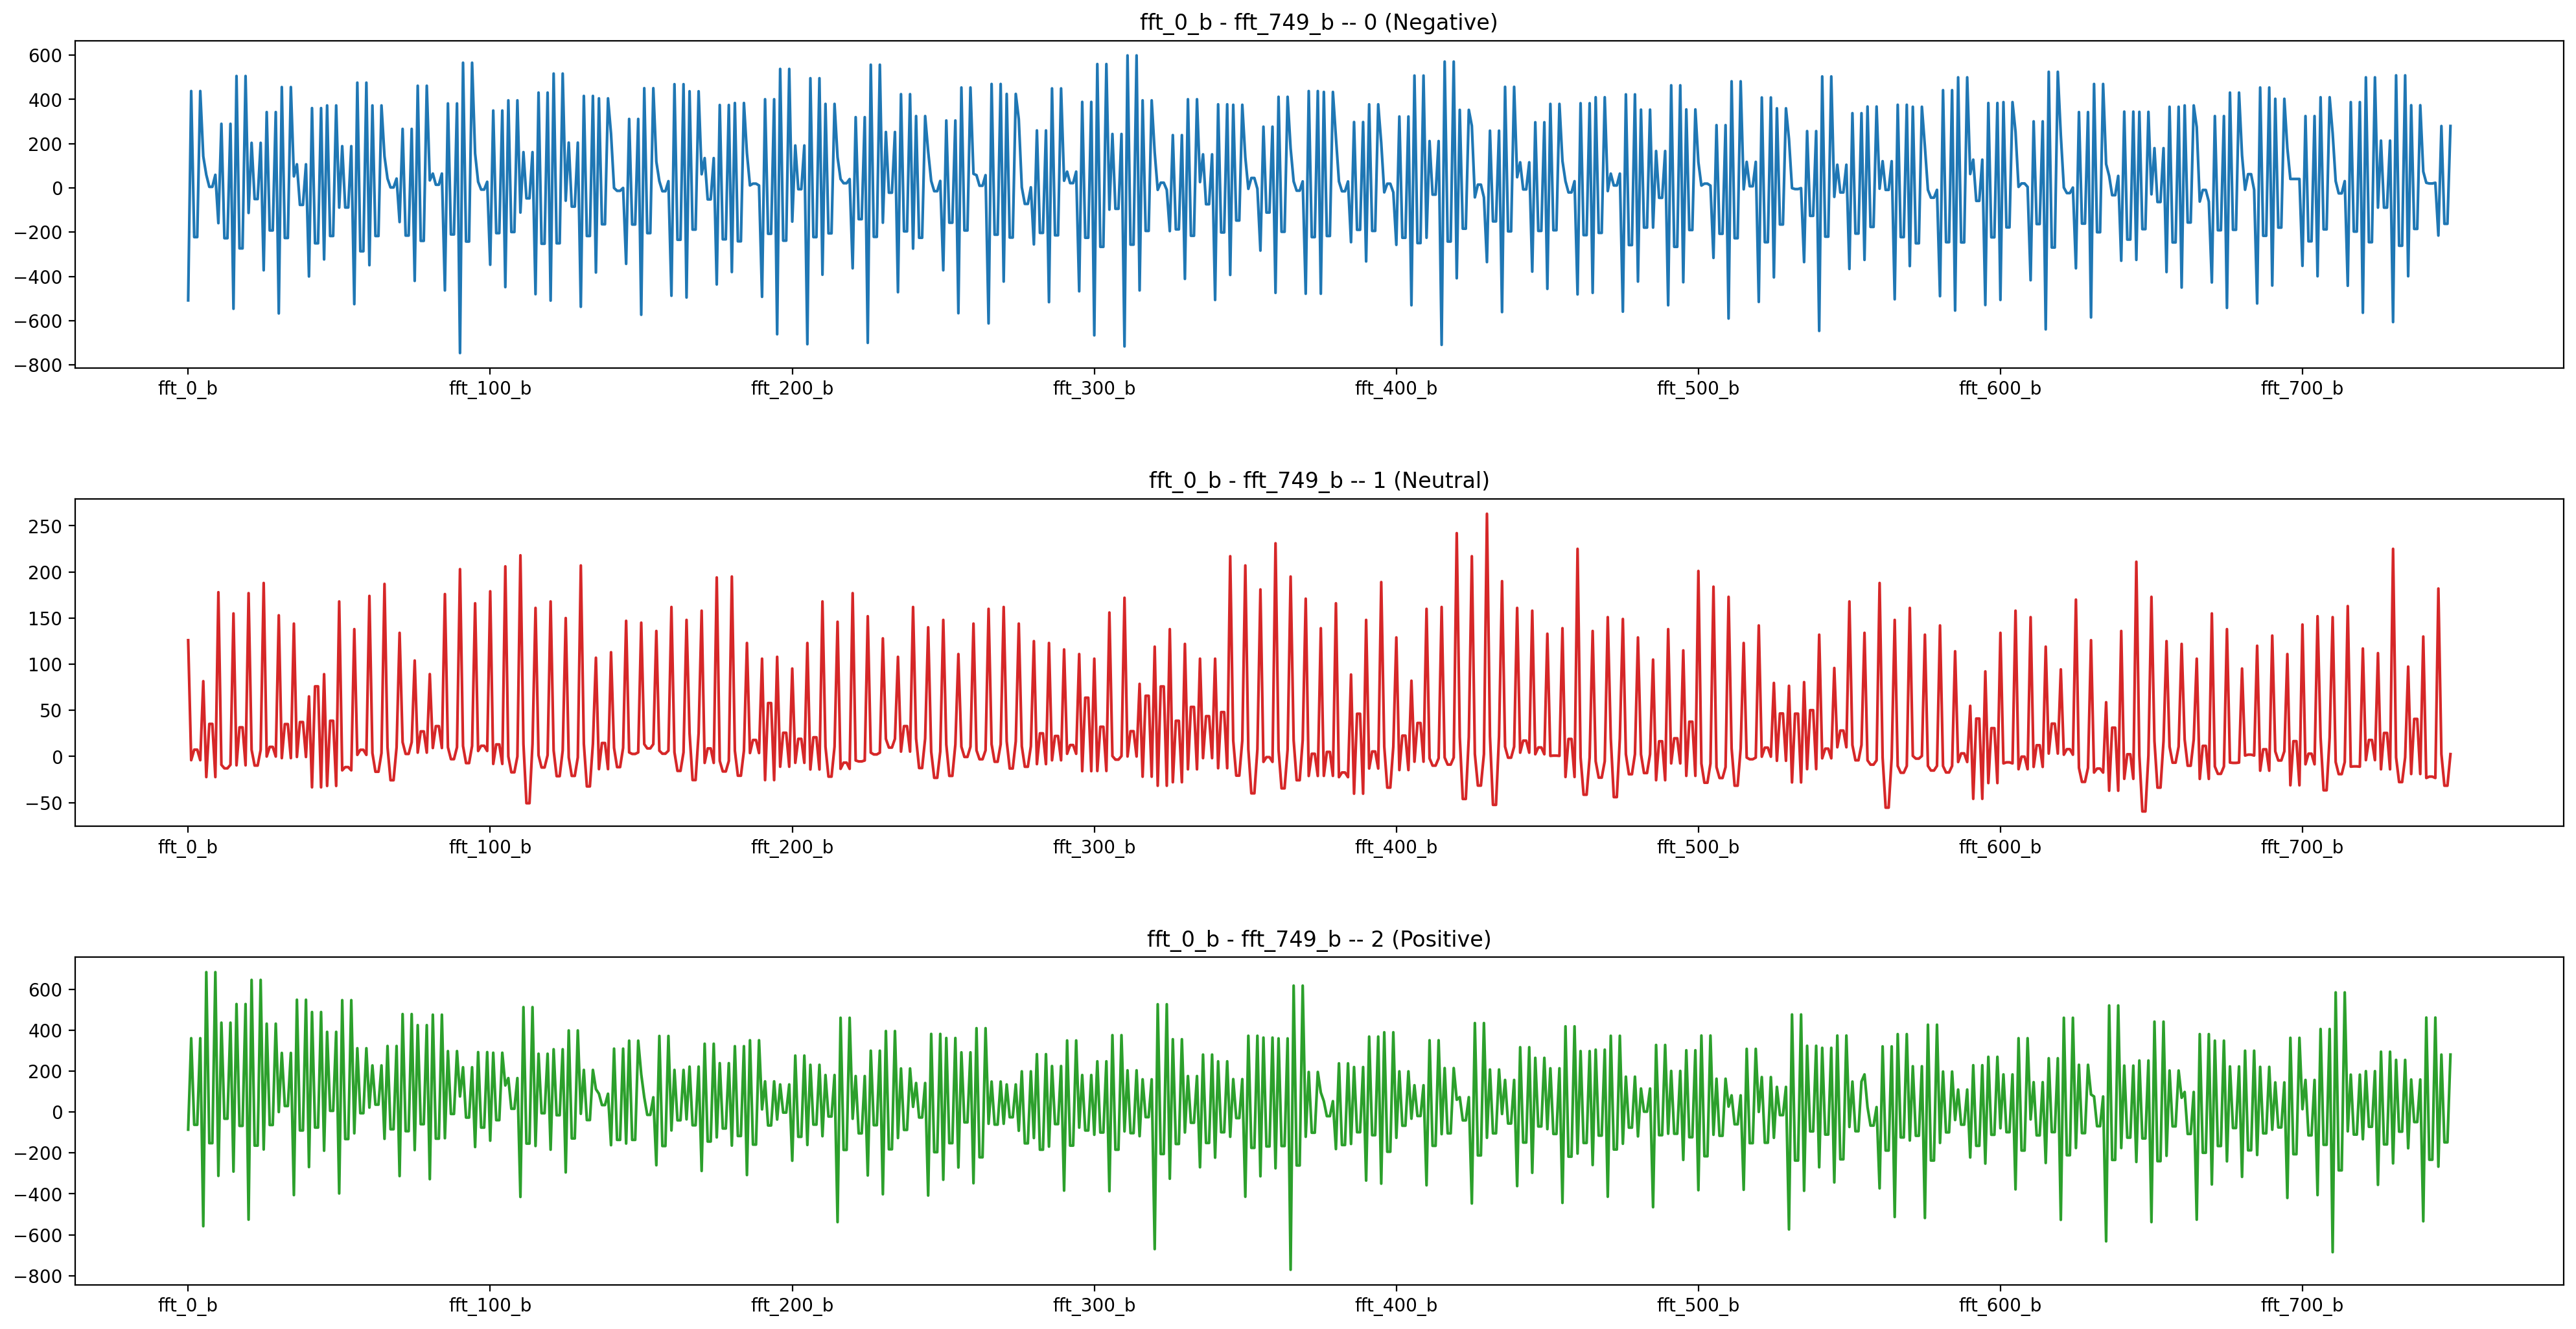

In [5]:
# visualize EEG samples
fig, axes = plt.subplots(nrows=3, ncols=1, dpi=200, figsize=(24, 12))
data.loc[0, 'fft_0_b':'fft_749_b'].plot(title='fft_0_b - fft_749_b -- 0 (Negative)', color='tab:blue', ax=axes[0])
data.loc[1, 'fft_0_b':'fft_749_b'].plot(title='fft_0_b - fft_749_b -- 1 (Neutral)', color='tab:red', ax=axes[1])
data.loc[2, 'fft_0_b':'fft_749_b'].plot(title='fft_0_b - fft_749_b -- 2 (Positive)', color='tab:green', ax=axes[2])

plt.subplots_adjust(left=0.1, bottom=0.1, 
                    right=0.9, top=0.9, 
                    wspace=0.4, hspace=0.4)

(2132, 129, 22)


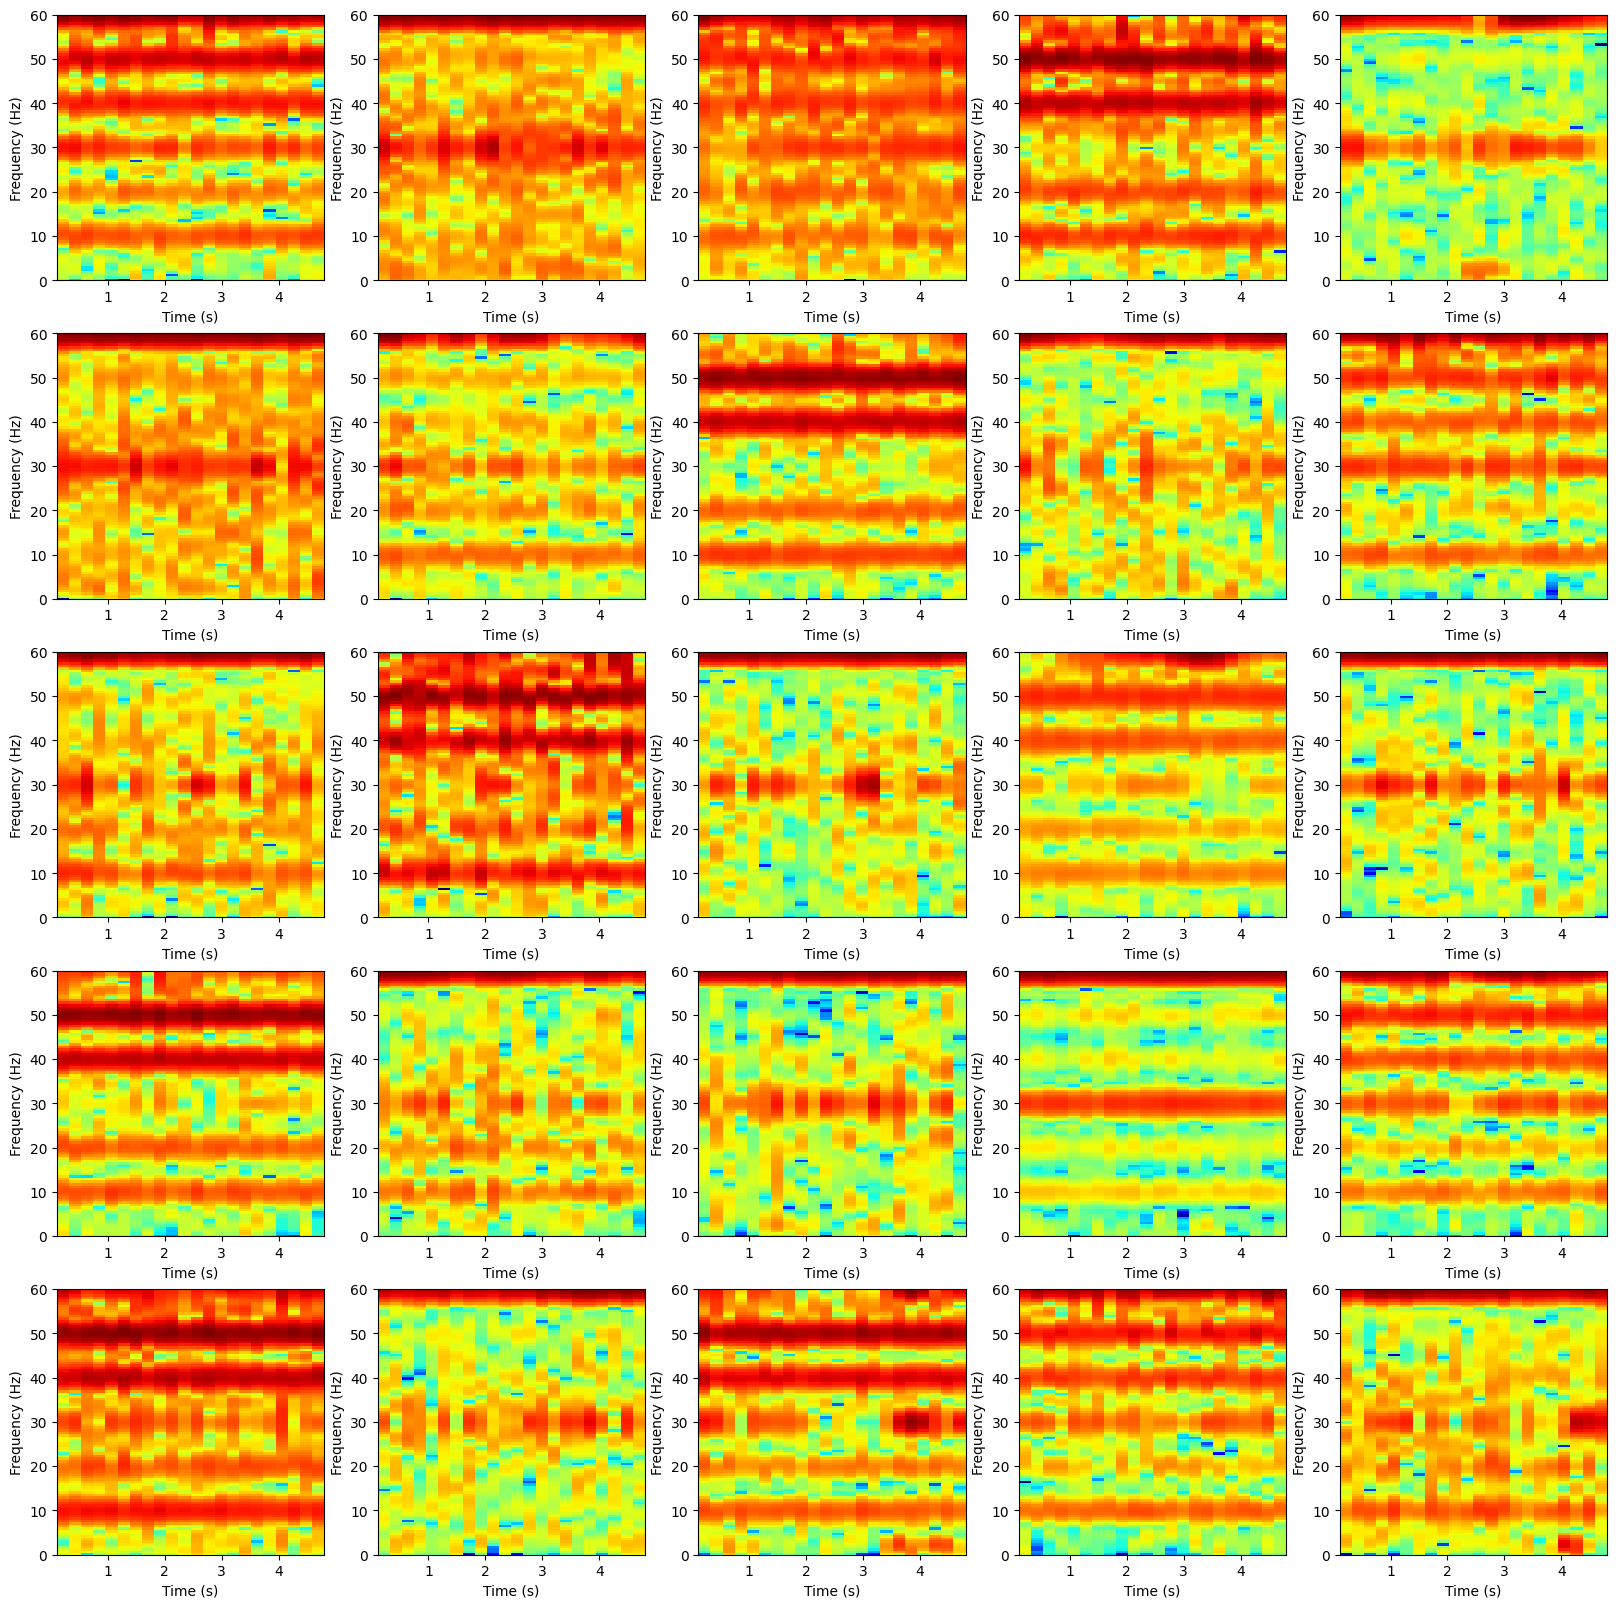

In [39]:
torch.set_default_dtype(torch.float32)
class EEGDataset(Dataset):
    def __init__(self, inputs, labels):
        self.x_train = torch.tensor(inputs)
        self.y_train = torch.tensor(labels)

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return self.x_train[idx], self.y_train[idx]

#preprocessing
inputs = data.drop('label', axis=1)
labels = data['label'].copy()
labels_onehot = np.eye(3)[labels]

scaler = StandardScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)

inputs = inputs[:, -750:]
window_size = 64
overlap = 32
fft_size = 256
sampling_rate = 150

spectrograms = []
for i in range(inputs.shape[0]):
    f, t, spectrogram = signal.spectrogram(inputs[i, :], fs=sampling_rate, window='hann', nperseg=window_size, noverlap=overlap, nfft=fft_size)
    spectrograms.append(spectrogram)
spectrograms = np.array(spectrograms)
print(spectrograms.shape)

#plot samples
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(spectrograms[i*5+j, :, :]), cmap='jet')
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        axs[i,j].set_ylim(0, 60)  # adjust the y-axis limit to show frequencies up to 60 Hz
plt.show()

spectrograms = np.expand_dims(spectrograms, axis=1)

#datasets
batch_size = 64
dataset = EEGDataset(spectrograms, labels_onehot)
train_data, test_data = torch.utils.data.random_split(dataset, [1705, 427])

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

dataset_gan = EEGDataset(spectrograms, labels)
gan_dataloader = DataLoader(dataset_gan, batch_size=batch_size, shuffle=True)

In [31]:
torch.set_default_dtype(torch.float64)
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
            nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, padding=0),
            nn.BatchNorm2d(num_features=12),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.25),
            nn.Flatten(),
            nn.Linear(in_features=1440, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=3),
        )

    def forward(self, x):
        x = self.features(x)
        x = F.softmax(x, dim=1)
        return x


def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight.data)

def eval(model, dataloader):
    model.eval()
    correct = 0
    loss_sum = 0
    total = 0
    for inputs, labels in dataloader:
        inputs = inputs.cuda()
        labels = labels.cuda()
        total += len(labels)
        outputs = model(inputs)
        loss_sum += criterion(outputs, labels).item()
        predictions = torch.max(outputs, dim=1)[1]
        labels = torch.max(labels, dim=1)[1]
        correct += (predictions == labels).sum().item()
    return 100.0 * correct / total, loss_sum / total


In [32]:
learning_rate = 1e-3

model = CNNNet()
model.apply(init_weights)
model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()

def train(model,
          optimizer=optimizer,
          scheduler=scheduler,
          criterion=criterion,
          epochs=200,
          train_dataloader=train_dataloader,
          test_dataloader=test_dataloader,
          patience = 25):
    """
    
    """

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    best_test_loss = math.inf
    stagnant_epochs = 0

    for epoch in range(0, epochs):
        print("\nEPOCH " +str(epoch+1)+" of "+str(epochs)+"\n")
        correct = 0
        total = 0
        loss_sum = 0
        for i, (signals, labels) in enumerate(train_dataloader):
            model.train()
            signals = signals.cuda()
            labels = labels.cuda()
            outputs = model.forward(signals)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_sum += loss
            total += len(labels)
            predictions = torch.max(outputs, dim=1)[1]
            labels = torch.max(labels, dim=1)[1]
            correct += (predictions == labels).sum().item()

        tr_acc, tr_loss = 100.0 * correct / total, loss_sum.item() / total
        train_losses.append(tr_loss)
        train_accs.append(tr_acc)
        print('  Train accuracy: %f %%' % tr_acc)
        print('  Train loss: %f' % tr_loss)

        tst_acc, tst_loss = eval(model, test_dataloader)
        test_losses.append(tst_loss)
        test_accs.append(tst_acc)
        print('  Test accuracy: %f %%' % tst_acc)
        print('  Test loss: %f' % tst_loss)

        if tst_loss < best_test_loss:
            best_test_loss = tst_loss
            stagnant_epochs = 0
        else:
            stagnant_epochs += 1
        if stagnant_epochs == patience:
            print("Early stop triggered.")
            break
        
        scheduler.step()
        print()
    
    return train_losses, train_accs, test_losses, test_accs

In [8]:
train_losses, train_accs, test_losses, test_accs = train(model)


EPOCH 1 of 200

  Train accuracy: 61.348974 %
  Train loss: 0.014678
  Test accuracy: 77.517564 %
  Test loss: 0.014955


EPOCH 2 of 200

  Train accuracy: 75.659824 %
  Train loss: 0.012833
  Test accuracy: 84.543326 %
  Test loss: 0.012745


EPOCH 3 of 200

  Train accuracy: 76.832845 %
  Train loss: 0.012445
  Test accuracy: 87.822014 %
  Test loss: 0.011761


EPOCH 4 of 200

  Train accuracy: 76.950147 %
  Train loss: 0.012494
  Test accuracy: 83.138173 %
  Test loss: 0.011912


EPOCH 5 of 200

  Train accuracy: 78.592375 %
  Train loss: 0.012207
  Test accuracy: 84.777518 %
  Test loss: 0.011912


EPOCH 6 of 200

  Train accuracy: 79.824047 %
  Train loss: 0.011950
  Test accuracy: 88.056206 %
  Test loss: 0.011507


EPOCH 7 of 200

  Train accuracy: 81.876833 %
  Train loss: 0.011767
  Test accuracy: 88.758782 %
  Test loss: 0.011172


EPOCH 8 of 200

  Train accuracy: 83.929619 %
  Train loss: 0.011466
  Test accuracy: 84.543326 %
  Test loss: 0.011593


EPOCH 9 of 200

  Train

In [9]:
#torch.save(model, "/content/gdrive/MyDrive/eeg_cnn.pt")

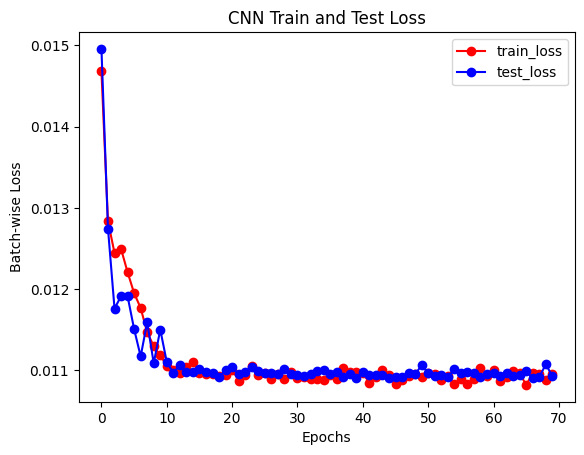

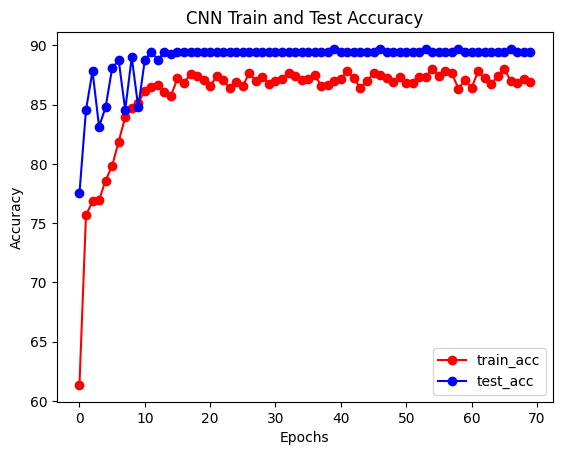

In [10]:
plt.plot(train_losses, '-o', label = 'train_loss', color = 'red')
plt.plot(test_losses, '-o', label = 'test_loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Batch-wise Loss')
plt.title('CNN Train and Test Loss')
plt.legend(loc="upper right")
plt.show()

plt.plot(train_accs, '-o', label = 'train_acc', color = 'red')
plt.plot(test_accs, '-o', label = 'test_acc', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Train and Test Accuracy')
plt.legend(loc="lower right")
plt.show()

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float64)


class Generator(nn.Module):
    def __init__(self, d=128):
        super(Generator, self).__init__()
        self.deconv1_1 = nn.ConvTranspose2d(in_channels=100, out_channels=d*2, kernel_size=4)
        self.deconv1_1_bn = nn.BatchNorm2d(num_features=d*2)
        self.deconv1_2 = nn.ConvTranspose2d(3, d*2, 4, 1, 0)
        self.deconv1_2_bn = nn.BatchNorm2d(d*2)
        self.deconv2 = nn.ConvTranspose2d(in_channels=d*4, out_channels=d*2, kernel_size=4, stride=2, padding=1)
        self.deconv2_bn = nn.BatchNorm2d(num_features=d*2)
        self.deconv3 = nn.ConvTranspose2d(in_channels=d*2, out_channels=d, kernel_size=4, stride=2, padding=1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(in_channels=d, out_channels=int(d/2), kernel_size=4, stride=2, padding=1)
        self.deconv4_bn = nn.BatchNorm2d(num_features=int(d/2))
        self.deconv5 = nn.ConvTranspose2d(in_channels=int(d/2), out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, z, label):
        x = F.relu(self.deconv1_1_bn(self.deconv1_1(z)))
        y = F.relu(self.deconv1_2_bn(self.deconv1_2(label)))
        x = torch.cat([x, y], dim=1)
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.relu(self.deconv4_bn(self.deconv4(x)))
        x = self.deconv5(x)
        x = torch.abs(F.interpolate(x, size=(129, 22), mode='bilinear', align_corners=False))
        return x

class Discriminator(nn.Module):
    def __init__(self, d=128):
        super(Discriminator, self).__init__()
        self.conv1_1 = nn.Conv2d(1, int(d/2), 4, 2, 1)
        self.conv1_2 = nn.Conv2d(3, int(d/2), 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d * 4, 1, 1, 1, 0)
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(32, 1))

    def forward(self, x, label):
        x = F.leaky_relu(self.conv1_1(x), 0.2)
        y = F.leaky_relu(self.conv1_2(label), 0.2)
        x = torch.cat([x, y], 1)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = F.sigmoid(self.fc(self.conv4(x)))
        return x

def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data)

def train_cgan(generator, discriminator, dataloader, num_epochs, d_optim, g_optim):

    criterion = nn.BCELoss()
    g_losses = []
    d_losses = []
    scheduler = torch.optim.lr_scheduler.StepLR(d_optim, step_size=25, gamma=0.1)

    onehot = torch.zeros(3, 3)
    onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2]).view(3,1), 1).view(3, 3, 1, 1)
    fill = torch.zeros([3, 3, 129, 22])
    for i in range(3):
        fill[i, i, :, :] = 1
    onehot = onehot.to(device)
    fill = fill.to(device)

    for epoch in range(num_epochs):

        for i, (images, labels) in enumerate(dataloader):
            real_images = images.to(device)
            real_labels = labels.to(device)
            batch_size = images.size(0)

            # Train discriminator
            d_optim.zero_grad()
            # Discriminate real signals and calculate loss
            real_validity = discriminator(real_images, fill[real_labels]).squeeze()
            real_loss = criterion(real_validity, torch.ones(batch_size).to(device))
            # Create noise, fake labels, and fake signals
            noise = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).to(device)
            fake_labels = (torch.rand(batch_size, 1) * 3).type(torch.LongTensor).squeeze().to(device)
            fake_images = generator(noise, onehot[fake_labels])
            # Discriminate fake signals and calculate loss
            fake_validity = discriminator(fake_images, fill[fake_labels]).squeeze()
            fake_loss = criterion(fake_validity, torch.zeros(batch_size).to(device))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optim.step()

            # Train generator
            g_optim.zero_grad()
            # Create noise, fake labels, and fake signals
            noise = torch.randn((batch_size, 100)).view(-1, 100, 1, 1).to(device)
            fake_labels = (torch.rand(batch_size, 1) * 3).type(torch.LongTensor).squeeze().to(device)
            fake_images = generator(noise, onehot[fake_labels])
            # Discriminate fake signals and calculate loss
            validity = discriminator(fake_images, fill[fake_labels]).squeeze()
            g_loss = criterion(validity, torch.ones(batch_size).to(device))
            g_loss.backward()
            g_optim.step()

            g_losses.append(g_loss.item())
            d_losses.append(d_loss.item())

        if epoch < 100:
            scheduler.step()
        print('Epoch [{}/{}], g_loss: {}, d_loss: {}'.format(epoch, num_epochs, g_loss, d_loss))
                
    return g_losses, d_losses

In [41]:
gen_lr = 2e-4
disc_lr = 2e-4
num_epochs = 50

generator = Generator().to(device)
discriminator = Discriminator().to(device)
generator.apply(init_weights)
discriminator.apply(init_weights)
g_optim = optim.Adam(generator.parameters(), lr=gen_lr, betas=(0.5, 0.999))
d_optim = optim.Adam(discriminator.parameters(), lr=disc_lr, betas=(0.5, 0.999))

g_loss, d_loss = train_cgan(generator, discriminator, gan_dataloader, num_epochs, d_optim, g_optim)

Epoch [0/50], g_loss: 7.176632806401887, d_loss: 0.17833161355623253
Epoch [1/50], g_loss: 4.594695083954379, d_loss: 0.06753723199287776
Epoch [2/50], g_loss: 4.433028413079907, d_loss: 0.05569712458923391
Epoch [3/50], g_loss: 4.688290313724713, d_loss: 0.03209546514534038
Epoch [4/50], g_loss: 4.5107910312335, d_loss: 0.016023571408415798
Epoch [5/50], g_loss: 4.651402253869025, d_loss: 0.01597276013084573
Epoch [6/50], g_loss: 4.60652266112477, d_loss: 0.036281905753166525
Epoch [7/50], g_loss: 4.580124105286525, d_loss: 0.0071063463928851605
Epoch [8/50], g_loss: 4.9884064100639165, d_loss: 0.0065396833320486795
Epoch [9/50], g_loss: 5.444271459570341, d_loss: 0.00794308995340306
learning rate change!
Epoch [10/50], g_loss: 5.4303702574949755, d_loss: 0.0021883975235395224
Epoch [11/50], g_loss: 5.390642808314464, d_loss: 0.005578894884791139
Epoch [12/50], g_loss: 5.127554346269074, d_loss: 0.007321204332299169
Epoch [13/50], g_loss: 5.157012692221525, d_loss: 0.00499259223136559

KeyboardInterrupt: ignored

In [21]:
torch.save(generator, "/content/gdrive/MyDrive/eeg_gen_tanh.pt")
torch.save(discriminator, "/content/gdrive/MyDrive/eeg_disc_tanh.pt")

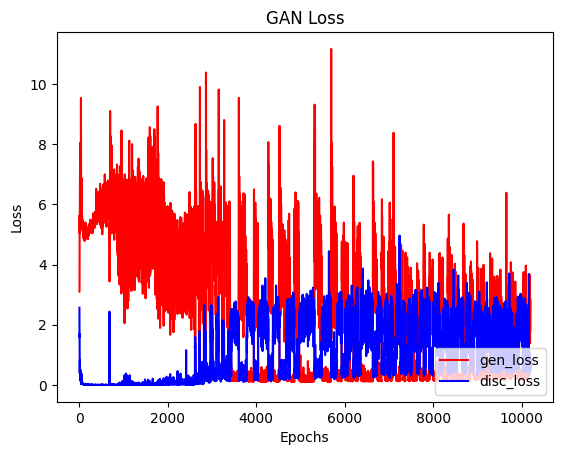

In [17]:
plt.plot(g_loss, label = 'gen_loss', color = 'red')
plt.plot(d_loss, label = 'disc_loss', color = 'blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('GAN Loss')
plt.legend(loc="lower right")
plt.show()

In [1]:
#generator = torch.load("/content/gdrive/MyDrive/eeg_dcgen.pt").to(device)

noise = torch.randn((1000, 100)).view(-1, 100, 1, 1).to(device)
onehot = torch.zeros(3, 3)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2]).view(3,1), 1).view(3, 3, 1, 1).to(device)
fake_labels = (torch.rand(1000, 1)*3).type(torch.LongTensor).squeeze().to(device)
images = generator(noise, onehot[fake_labels])
images = images.detach()
images_np = images.squeeze(1).cpu().numpy()
'''
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(20, 20))
for i in range(5):
    for j in range(5):
        axs[i,j].pcolormesh(t, f, 20*np.log10(images_np[i*5+j, :, :]), cmap='jet')
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_ylabel('Frequency (Hz)')
        axs[i,j].set_ylim(0, 60)  # adjust the y-axis limit to show frequencies up to 60 Hz
plt.show()
'''

model = torch.load("/content/gdrive/MyDrive/eeg_cnn.pt")

def synth_eval(model, images, labels):
    model.eval()
    correct = 0
    loss_sum = 0
    total = len(labels)
    criterion = nn.CrossEntropyLoss()
    images = images.cuda()
    labels = labels.cuda()

    outputs = model(images)
    loss_sum += criterion(outputs, labels).item()
    predictions = torch.max(outputs, dim=1)[1]
    labels = torch.max(labels, dim=1)[1]
    correct += (predictions == labels).sum().item()

    return 100.0 * correct / total, loss_sum / total, labels, predictions == labels

synth_acc, synth_loss, tr_labels, correct = synth_eval(model, images, onehot[fake_labels].squeeze(2).squeeze(2))
print(synth_acc, synth_loss)

NameError: ignored

In [32]:
half_train, half_test = torch.utils.data.random_split(dataset, [1066, 1066])
half_train_dataloader = DataLoader(half_train, batch_size=batch_size, shuffle=True)
half_test_dataloader = DataLoader(half_test, batch_size=batch_size, shuffle=False)

learning_rate = 1e-3
model = CNNNet()
model.apply(init_weights)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.CrossEntropyLoss()


train(model,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    epochs=200,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    patience = 25)


EPOCH 1 of 200

  Train accuracy: 65.395894 %
  Train loss: 0.014357
  Test accuracy: 79.391101 %
  Test loss: 0.014986


EPOCH 2 of 200

  Train accuracy: 76.598240 %
  Train loss: 0.012696
  Test accuracy: 73.302108 %
  Test loss: 0.013043


EPOCH 3 of 200

  Train accuracy: 81.055718 %
  Train loss: 0.012099
  Test accuracy: 86.416862 %
  Test loss: 0.011588


EPOCH 4 of 200

  Train accuracy: 85.161290 %
  Train loss: 0.011399
  Test accuracy: 89.461358 %
  Test loss: 0.011233


EPOCH 5 of 200

  Train accuracy: 86.920821 %
  Train loss: 0.011110
  Test accuracy: 89.461358 %
  Test loss: 0.010965


EPOCH 6 of 200

  Train accuracy: 87.683284 %
  Train loss: 0.010926
  Test accuracy: 87.587822 %
  Test loss: 0.011168


EPOCH 7 of 200

  Train accuracy: 87.448680 %
  Train loss: 0.010878
  Test accuracy: 89.461358 %
  Test loss: 0.010904


EPOCH 8 of 200

  Train accuracy: 88.093842 %
  Train loss: 0.010756
  Test accuracy: 89.929742 %
  Test loss: 0.010778


EPOCH 9 of 200

  Train

([0.014357161507754403,
  0.012696499922325062,
  0.012098535753897388,
  0.011399349950932206,
  0.011109985812880216,
  0.010926404463350105,
  0.01087786072781932,
  0.010756205425199275,
  0.01063342696163168,
  0.010578574849969945,
  0.010550777723685826,
  0.010546578138917236,
  0.010539889338831057,
  0.010539384341581708,
  0.010536356203279812,
  0.010432524895447472,
  0.010455110747853635,
  0.010497909607892436,
  0.010458115580713682,
  0.010489146530082741,
  0.010439796399817274,
  0.010472542959563909,
  0.010445324402431719,
  0.010465462495849091,
  0.01043397687958084,
  0.01043310485959994,
  0.010447319272261333,
  0.010466540183164492,
  0.010446820416935471,
  0.010470062508773586,
  0.010507681438642677,
  0.010472203878846903,
  0.010466920886392575,
  0.010468754643343669,
  0.010477712507299423,
  0.010462552689248191,
  0.010433848632240872,
  0.010473862780593528,
  0.010432509129777884,
  0.010452866725848104,
  0.010428765164535326,
  0.0104614726479909

In [33]:
torch.save(model, "/content/gdrive/MyDrive/eeg_cnn_half.pt")

In [36]:
noise = torch.randn((1000, 100)).view(-1, 100, 1, 1).to(device)
onehot = torch.zeros(3, 3)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2]).view(3,1), 1).view(3, 3, 1, 1).to(device)
fake_labels = (torch.rand(1000, 1) * 3).type(torch.LongTensor).squeeze().to(device)
images = generator(noise, onehot[fake_labels])
images = images.detach()
synth_dataset = EEGDataset(images, onehot[fake_labels].squeeze(2).squeeze(2))
synth_loader = DataLoader(synth_dataset, batch_size=batch_size, shuffle=True)

train_losses, train_accs, test_losses, test_accs = train(model, criterion=criterion)

<ipython-input-5-da0def4d323c>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x_train = torch.tensor(inputs)
<ipython-input-5-da0def4d323c>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y_train = torch.tensor(labels)



EPOCH 1 of 200

  Train accuracy: 89.442815 %
  Train loss: 0.010473
  Test accuracy: 90.163934 %
  Test loss: 0.010668


EPOCH 2 of 200

  Train accuracy: 89.618768 %
  Train loss: 0.010443
  Test accuracy: 90.163934 %
  Test loss: 0.010677


EPOCH 3 of 200

  Train accuracy: 89.266862 %
  Train loss: 0.010498
  Test accuracy: 90.163934 %
  Test loss: 0.010660


EPOCH 4 of 200

  Train accuracy: 89.325513 %
  Train loss: 0.010512
  Test accuracy: 90.163934 %
  Test loss: 0.010665


EPOCH 5 of 200

  Train accuracy: 89.794721 %
  Train loss: 0.010429
  Test accuracy: 90.163934 %
  Test loss: 0.010675


EPOCH 6 of 200

  Train accuracy: 89.501466 %
  Train loss: 0.010458
  Test accuracy: 90.163934 %
  Test loss: 0.010669


EPOCH 7 of 200

  Train accuracy: 89.736070 %
  Train loss: 0.010447
  Test accuracy: 90.163934 %
  Test loss: 0.010667


EPOCH 8 of 200

  Train accuracy: 89.149560 %
  Train loss: 0.010504
  Test accuracy: 90.163934 %
  Test loss: 0.010659


EPOCH 9 of 200

  Train

In [43]:
input_tensor = None
for images, labels in train_dataloader:
    input_tensor = images.to(device)
    break

model = torch.load("/content/gdrive/MyDrive/eeg_cnn.pt")
graph = make_dot(model(input_tensor), params=dict(model.named_parameters()))
graph.render("my_model_graph")

'my_model_graph.pdf'

In [47]:
noise = torch.randn((1000, 100)).view(-1, 100, 1, 1).to(device)
onehot = torch.zeros(3, 3)
onehot = onehot.scatter_(1, torch.LongTensor([0, 1, 2]).view(3,1), 1).view(3, 3, 1, 1).to(device)
fake_labels = (torch.rand(1000, 1) * 3).type(torch.LongTensor).squeeze().to(device)
graph = make_dot(generator(noise, onehot[fake_labels]), params=dict(generator.named_parameters()))
graph.render("generator_graph")

'generator_graph.pdf'